In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import os
import time
import copy
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torchaudio
from sklearn.preprocessing import LabelEncoder
labelen_xy=LabelEncoder()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
import numpy as np
import os
datadir="/content/drive/MyDrive/DSPDATAM/traindata"
cata=["down","fear","left","no","right","siren","stop","surprise"]
p=[]

for cat in cata:
  path=os.path.join(datadir,cat)

  for pat in os.listdir(path):
    #print(pat)
    p.append([pat,cat])


In [ ]:
datadirv="/content/drive/MyDrive/DSPDATAM/testdata"
cata=["down","fear","left","no","right","siren","stop","surprise"]
pv=[]

for cat in cata:
  path=os.path.join(datadirv,cat)

  for pat in os.listdir(path):
    #print(pat)
    pv.append([pat,cat])

LABEL

In [ ]:
p1v=[]
p1v=np.array(pv)
print(len(p1v))
p1v[:,1]=labelen_xy.fit_transform(p1v[:,1])
qv=p1v[:,[1]]
print(qv)
qv=qv.astype('int64')
qv=torch.from_numpy(qv)
print(qv.shape[0])
qov=torch.zeros(qv.shape[0],8)
qov=qov.scatter_(1,qv,1.0)
print(qov[1])

1466
[['0']
 ['0']
 ['0']
 ...
 ['7']
 ['7']
 ['7']]
1466
tensor([1., 0., 0., 0., 0., 0., 0., 0.])


DATALOADER

In [ ]:
sr=22050
ns=22050
mel=torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                         n_fft=1024,
                                         hop_length=512,
                                         n_mels=64)

Mel spectogram

In [ ]:
from sklearn.preprocessing import StandardScaler
class DATA(Dataset):
  def __init__(self,p,qo,datadir,transform,tsr,ns,device):
    self.p=p
    self.datadir=datadir
    self.device=device
    self.transform=transform.to(self.device)
    self.tsr=tsr
    self.ns=ns


  def __len__(self):
    return len(self.p)
  def __getitem__(self,index):
    audio_sample_path=self._get_audio_sample_path(index)
    label=self._get_audio_sample_label(index)
    signal,sr=torchaudio.load(audio_sample_path)
    signal=signal.to(self.device)
    #signal=signal.astype('float32')
    signal=self._resample_if_necessary(signal,sr)
    signal=self._mix_down_if_necessary(signal)
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    signal=self.transform(signal)
    signal=signal.to('cpu')
    signal=torch.squeeze(signal,0)


    scaler = StandardScaler()
    signal = scaler.fit_transform(signal.numpy())
    signal=torch.from_numpy(signal)
    signal=torch.unsqueeze(signal,0)

    signal=signal.to(device)
    return signal,qo[index]
  def _get_audio_sample_path(self,index):
    path=os.path.join(self.datadir,self.p[index][1],self.p[index][0])
    return path
  def _get_audio_sample_label(self,index):
    return self.p[index][1]
  def _resample_if_necessary(self,signal,sr):
    if(sr!=self.tsr):
      res=torchaudio.transforms.Resample(sr,self.tsr).to(device)
      signal=res(signal)
    return signal
  def _mix_down_if_necessary(self,signal):
    if signal.shape[0]>1:
      signal=torch.mean(signal,dim=0,keepdim=True)
    return signal
  def _cut_if_necessary(self, signal):
    if signal.shape[1] > self.ns:
      signal = signal[:, :self.ns]
    return signal

  def _right_pad_if_necessary(self, signal):
    length_signal = signal.shape[1]
    if length_signal < self.ns:
      num_missing_samples = self.ns - length_signal
      last_dim_padding = (0, num_missing_samples)
      signal = torch.nn.functional.pad(signal, last_dim_padding)
    return signal

In [ ]:
data=DATA(p,qo,datadir,mel,sr,ns,device)
#data1=DATA(pv,qov,datadirv,mel,sr,ns,device)
print(data[1])
#print(data1[0])
print(len(data))
#print(len(data1))

(tensor([[[ 2.2500,  1.8388,  6.5192,  ...,  5.8138,  7.3812, -0.2252],
         [ 0.7714,  4.7589,  1.7373,  ...,  3.3111,  1.5934,  3.9096],
         [ 3.6329,  3.3875,  1.4150,  ...,  0.4213,  0.6912,  4.3525],
         ...,
         [-0.4405, -0.6604, -0.3877,  ..., -0.7073, -0.3675, -0.5488],
         [-0.4405, -0.6604, -0.3877,  ..., -0.7073, -0.3675, -0.5489],
         [-0.4405, -0.6604, -0.3877,  ..., -0.7073, -0.3675, -0.5490]]],
       device='cuda:0'), tensor([1., 0., 0., 0., 0., 0., 0., 0.]))
(tensor([[[ 7.9112e+00,  7.8052e+00, -1.7133e-01,  ...,  7.8834e+00,
           6.3496e+00,  7.3501e+00],
         [ 2.9761e-01,  1.2815e+00,  1.4244e+00,  ...,  3.9802e-01,
           4.6041e+00,  2.6112e+00],
         [-3.0590e-02,  6.8328e-04,  4.0400e+00,  ...,  6.0785e-02,
           5.1960e-01, -1.6750e-01],
         ...,
         [-2.2299e-01, -1.9615e-01, -4.0966e-01,  ..., -1.9846e-01,
          -2.2081e-01, -2.5855e-01],
         [-2.2338e-01, -1.9624e-01, -4.0996e-01,  ..., 

In [ ]:
tr=data
ts=data1

In [ ]:
from sklearn.model_selection import train_test_split
tr, ts = train_test_split(data, test_size=0.15, random_state=42)
torch.save(tr, '/content/drive/MyDrive/DSPDATAM/traindataset2.pt')
torch.save(ts, '/content/drive/MyDrive/DSPDATAM/testdataset2.pt')


In [ ]:
tr=torch.load('/content/drive/MyDrive/DSPDATAM/SAVE/traindataset2.pt')
ts=torch.load('/content/drive/MyDrive/DSPDATAM/SAVE/testdataset2.pt')



In [ ]:
trl=DataLoader(dataset=tr,batch_size=62,shuffle=True)
tsl=DataLoader(dataset=ts,batch_size=62,shuffle=True)

In [ ]:
print(len(tr))
print(len(ts))
print(tr[0])


8643
1526
(tensor([[[-0.0979,  3.8913,  5.8243,  ...,  7.5515,  7.7654,  2.5155],
         [ 5.4905,  4.9966,  3.0787,  ...,  1.0050,  0.5467,  7.1842],
         [ 4.1459,  3.5869,  1.7674,  ...,  0.2230, -0.0374,  1.5963],
         ...,
         [-0.5581, -0.4847, -0.4550,  ..., -0.3644, -0.3326, -0.3194],
         [-0.5581, -0.4847, -0.4550,  ..., -0.3644, -0.3326, -0.3195],
         [-0.5580, -0.4847, -0.4550,  ..., -0.3644, -0.3326, -0.3196]]],
       device='cuda:0'), tensor([0., 0., 1., 0., 0., 0., 0., 0.]))


MODEL CLASS

In [ ]:
from torch import nn
from torchsummary import summary
class cnn(nn.Module):
 def __init__(self):
    super().__init__()
    self.conv1=nn.Sequential(nn.Conv2d(
    in_channels=1,
    out_channels=16,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.conv2=nn.Sequential(nn.Conv2d(
    in_channels=16,
    out_channels=32,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.conv3=nn.Sequential(nn.Conv2d(
    in_channels=32,
    out_channels=64,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.conv4=nn.Sequential(nn.Conv2d(
    in_channels=64,
    out_channels=128,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.flatten=nn.Flatten()
    self.linear=nn.Sequential(nn.Linear(128*5*4,512),
                              nn.ReLU(),
                              nn.Linear(512,8)
    )
    self.tan=nn.Tanh()
 def forward(self,input_data):
   x=self.conv1(input_data)
   x=self.conv2(x)
   x=self.conv3(x)
   x=self.conv4(x)
   x=self.flatten(x)
   logits=self.linear(x)
   predictions=self.tan(logits)
   return predictions





MODEL INITIALIZATION

In [ ]:
model=cnn().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
summary(model.to(device),(1,64,44))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                  [

In [ ]:
def accuracy(outputs, labels):
    preds = torch.max(outputs,dim=1)
    L=torch.max(labels,dim=1)
    return torch.tensor(torch.sum(preds[1] == L[1]).item() / len(preds[1]))*100

In [ ]:
nepoch=100
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
test_loss=[]
for epoch in range (nepoch):
  running_loss = 0.0
  i=0
  acc=0

  for batch_idx, (d, w) in enumerate(trl):
    i+=1
    d=d.to(device)
    w=w.to(device)
    o=model(d)
    loss=criterion(o,w)
    acc+=accuracy(o,w)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
  acc=acc/i
  train_loss.append(running_loss/len(trl))
  train_acc.append(acc)
  if epoch%5==0:
    print("@@",len(o))
    print(f'Epoch:{epoch},Loss:{loss.item():.4f},TRAIN ACCURACY:{acc}%')
  batch_loss = 0
  i=0
  acc=0

  for dt,wt in tsl:
    i+=1
    dt=dt.to(device)
    wt=wt.to(device)
    ot=model(dt)
    loss_t=criterion(ot,wt)
    acc+=accuracy(ot,wt)
    batch_loss += loss_t.item()
  acc=acc/i
  test_loss.append(batch_loss/len(tsl))
  test_acc.append(acc)
  if epoch%5==0:
    print(f'Epoch:{epoch},Loss:{loss_t.item():.4f},TEST ACCURACY:{acc}%')

@@ 25
Epoch:0,Loss:0.8203,TRAIN ACCURACY:55.00646209716797%
Epoch:0,Loss:0.9524,TEST ACCURACY:87.11035919189453%
@@ 25
Epoch:5,Loss:0.7431,TRAIN ACCURACY:95.63965606689453%
Epoch:5,Loss:0.6731,TEST ACCURACY:94.3871078491211%
@@ 25
Epoch:10,Loss:0.7387,TRAIN ACCURACY:96.91291046142578%
Epoch:10,Loss:0.7411,TEST ACCURACY:94.11205291748047%
@@ 25
Epoch:15,Loss:0.6668,TRAIN ACCURACY:96.90092468261719%
Epoch:15,Loss:0.7037,TEST ACCURACY:94.66893768310547%
@@ 25
Epoch:20,Loss:0.7795,TRAIN ACCURACY:96.99356842041016%
Epoch:20,Loss:0.6898,TEST ACCURACY:94.41085815429688%
@@ 25
Epoch:25,Loss:0.6665,TRAIN ACCURACY:96.60140228271484%
Epoch:25,Loss:0.7713,TEST ACCURACY:93.78945922851562%
@@ 25
Epoch:30,Loss:0.7230,TRAIN ACCURACY:97.05667877197266%
Epoch:30,Loss:0.7273,TEST ACCURACY:94.41085052490234%
@@ 25
Epoch:35,Loss:0.6665,TRAIN ACCURACY:97.1428451538086%
Epoch:35,Loss:0.7408,TEST ACCURACY:94.69268798828125%
@@ 25
Epoch:40,Loss:0.7230,TRAIN ACCURACY:97.18338775634766%
Epoch:40,Loss:0.7131,TEST

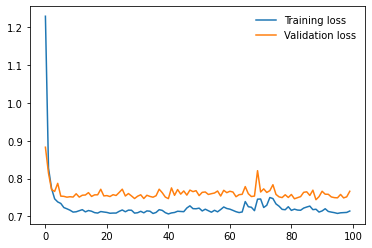

In [ ]:
# plt.plot(np.arange(1,nepoch+1),train_loss)
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

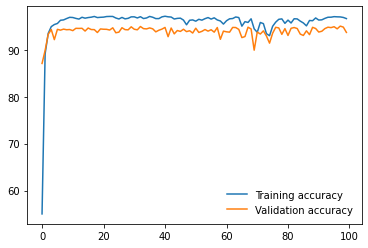

In [ ]:
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

In [ ]:
torch.save(model,'/content/drive/MyDrive/DSPDATAM/SAVE/AUDIO200.ptf')


In [ ]:
model=torch.load('/content/drive/MyDrive/DSPDATAM/SAVE/AUDIO200.ptf')

PREDICT

LOADING MODEL

In [ ]:
sr=22050
ns=22050
mel=torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                         n_fft=1024,
                                         hop_length=512,
                                         n_mels=64)

def get (p2,transform,tsr,ns):
  signal,sr=torchaudio.load(p2)
  #signal=signal.astype('float32')
  signal=_resample_if_necessary(signal,sr,tsr)
  signal=_mix_down_if_necessary(signal)
  signal = _cut_if_necessary(signal,ns)
  signal = _right_pad_if_necessary(signal,ns)
  signal=transform(signal)
  return signal

def _resample_if_necessary(signal,sr,tsr):
  if(sr!=tsr):
    res=torchaudio.transforms.Resample(sr,tsr)
    signal=res(signal)
  return signal
def _mix_down_if_necessary(signal):
  if signal.shape[0]>1:
    signal=torch.mean(signal,dim=0,keepdim=True)
  return signal
def _cut_if_necessary(signal,ns):
  if signal.shape[1] > ns:
    signal = signal[:, :ns]
  return signal

def _right_pad_if_necessary(signal,ns):
  length_signal = signal.shape[1]
  if length_signal < ns:
    num_missing_samples = ns - length_signal
    last_dim_padding = (0, num_missing_samples)
    signal = torch.nn.functional.pad(signal, last_dim_padding)
  return signal

PREDICT

CODE REQUIRED FOR RASPBERRY PI

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchvision import datasets, transforms

import numpy as np
import os
import time
import numpy as np
from PIL import Image
import torchvision
from torch import nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torchaudio
from torch import nn

sr=22050
ns=22050
mel=torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                         n_fft=1024,
                                         hop_length=512,
                                         n_mels=64)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from torchsummary import summary
class cnn(nn.Module):
 def __init__(self):
    super().__init__()
    self.conv1=nn.Sequential(nn.Conv2d(
    in_channels=1,
    out_channels=16,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.conv2=nn.Sequential(nn.Conv2d(
    in_channels=16,
    out_channels=32,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.conv3=nn.Sequential(nn.Conv2d(
    in_channels=32,
    out_channels=64,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.conv4=nn.Sequential(nn.Conv2d(
    in_channels=64,
    out_channels=128,
    kernel_size=3,
    stride=1,
    padding=2
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    )
    self.flatten=nn.Flatten()
    self.linear=nn.Sequential(nn.Linear(128*5*4,512),
                              nn.ReLU(),
                              nn.Linear(512,8)
    )
    self.tan=nn.Tanh()
 def forward(self,input_data):
   x=self.conv1(input_data)
   x=self.conv2(x)
   x=self.conv3(x)
   x=self.conv4(x)
   x=self.flatten(x)
   logits=self.linear(x)
   predictions=self.tan(logits)
   return predictions


model=cnn()
model=torch.load('/content/drive/MyDrive/DSPDATAM/SAVE/AUDIO200.ptf')


sr=22050
ns=22050
mel=torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                         n_fft=1024,
                                         hop_length=512,
                                         n_mels=64)
def get (p2,transform,tsr,ns):
  signal,sr=torchaudio.load(p2)
  #signal=signal.astype('float32')
  signal=_resample_if_necessary(signal,sr,tsr)
  signal=_mix_down_if_necessary(signal)
  signal = _cut_if_necessary(signal,ns)
  signal = _right_pad_if_necessary(signal,ns)
  signal=transform(signal)
  return signal

def _resample_if_necessary(signal,sr,tsr):
  if(sr!=tsr):
    res=torchaudio.transforms.Resample(sr,tsr)
    signal=res(signal)
  return signal
def _mix_down_if_necessary(signal):
  if signal.shape[0]>1:
    signal=torch.mean(signal,dim=0,keepdim=True)
  return signal
def _cut_if_necessary(signal,ns):
  if signal.shape[1] > ns:
    signal = signal[:, :ns]
  return signal

def _right_pad_if_necessary(signal,ns):
  length_signal = signal.shape[1]
  if length_signal < ns:
    num_missing_samples = ns - length_signal
    last_dim_padding = (0, num_missing_samples)
    signal = torch.nn.functional.pad(signal, last_dim_padding)
  return signal

p2="/content/drive/MyDrive/DSPDATAM/testdata/left/1737.wav"
an= get (p2,mel,sr,ns)
t=torch.unsqueeze(an,0)
t=t.to(device)
o=model(t)
key=0
o=o.squeeze(0)
output=["DOWN","FEAR","LEFT","NO","RIGHT","SIREN","STOP","SURPRISE"]
for j in range(0,8):
  if(o[j]>0):
    key=1
    print(output[j])
    break
if(key==1):
  print("Lower the windsheild")


LEFT
Lower the windsheild
